# Main Quest - Housing Price Prediction (Keggle)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [2]:
train_df = pd.read_csv('./data/housing_price_train.csv')

## 1. EDA

In [3]:
print(train_df.shape)
print(train_df.info())
train_df.head()

(1168, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal,122900


### 1.1 Target distribution

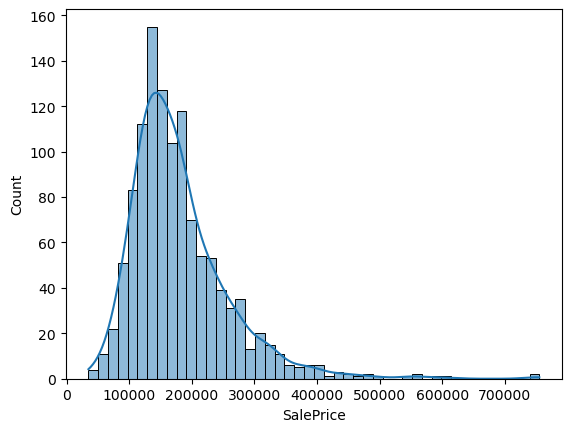

In [4]:
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

- Skewed to the right

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1168.0,728.528253,415.393477,1.0,373.75,720.5,1086.25,1460.0
MSSubClass,1168.0,56.977740,42.290680,20.0,20.00,50.0,70.00,190.0
LotFrontage,950.0,70.058947,24.762405,21.0,59.00,69.0,80.00,313.0
LotArea,1168.0,10336.357877,8784.854640,1300.0,7560.00,9446.0,11601.50,164660.0
OverallQual,1168.0,6.105308,1.373032,1.0,5.00,6.0,7.00,10.0
OverallCond,1168.0,5.595890,1.127388,1.0,5.00,5.0,6.00,9.0
YearBuilt,1168.0,1971.201199,30.362445,1872.0,1954.00,1972.5,2001.00,2010.0
YearRemodAdd,1168.0,1985.021404,20.693264,1950.0,1966.75,1994.0,2004.00,2010.0
MasVnrArea,1160.0,102.938793,176.142597,0.0,0.00,0.0,168.00,1170.0
BsmtFinSF1,1168.0,442.928938,462.364719,0.0,0.00,374.5,714.50,5644.0


### 1-2. 결측치

In [6]:
null_counts = train_df.isnull().sum()
null_counts[null_counts>0]

LotFrontage      218
Alley           1098
MasVnrType       694
MasVnrArea         8
BsmtQual          23
BsmtCond          23
BsmtExposure      24
BsmtFinType1      23
BsmtFinType2      24
Electrical         1
FireplaceQu      545
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
PoolQC          1162
Fence            941
MiscFeature     1120
dtype: int64

In [7]:
def create_missing_df(df):
    # 결측치 계산
    null_counts = df.isnull().sum()
    missing_ratio = (null_counts / len(df))
    
    # 결측치 있는 컬럼만
    missing_cols = null_counts[null_counts > 0].index
    
    # missing_df 생성
    missing_df = pd.DataFrame({
        'MissingCount': null_counts[missing_cols],
        'MissingRatio': missing_ratio[missing_cols],
        'Dtype': [train_df[col].dtype for col in missing_cols]  # 컬럼별 dtype
    })
    
    # 정렬
    missing_df = missing_df.sort_values(by='MissingRatio', ascending=False)
    
    return missing_df

In [8]:
missing_df = create_missing_df(train_df)
missing_df

,MissingCount,MissingRatio,Dtype
PoolQC,1162,0.994863,object
MiscFeature,1120,0.958904,object
Alley,1098,0.940068,object
Fence,941,0.805651,object
MasVnrType,694,0.594178,object
FireplaceQu,545,0.466610,object
LotFrontage,218,0.186644,float64
GarageType,69,0.059075,object
GarageYrBlt,69,0.059075,float64
GarageFinish,69,0.059075,object


- 결측치가 전체의 90% 이상인 컬럼 삭제

In [9]:
drop_cols = missing_df[missing_df['MissingRatio']>90].index.to_list()
train_df.drop(columns=drop_cols, inplace=True, errors='ignore')

- Fance 의 경우는 null값을 None으로 생각 (펜스 없음)

In [10]:
train_df['Fence'] = train_df['Fence'].fillna('None')

- MasVnrType(석조베니어타입)과  FireplaceQu(벽난로 품질)도 drop
    - 중요하지 않다고 판단 

In [11]:
train_df.drop(columns=['MasVnrType', 'FireplaceQu'], inplace=True, errors='ignore')

- float 특성들은 중앙값으로 imputation
- object 특성들은 최빈값으로 imputation

In [12]:
missing_df = create_missing_df(train_df)

In [13]:
num_missing_cols =  missing_df[missing_df['Dtype'] == 'float64'].index.to_list()
cat_missing_cols =  missing_df[missing_df['Dtype'] == 'object'].index.to_list()
print(num_missing_cols, cat_missing_cols, sep='\n')

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
['PoolQC', 'MiscFeature', 'Alley', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Electrical']


In [14]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

train_df[num_missing_cols] = num_imputer.fit_transform(train_df[num_missing_cols])
train_df[cat_missing_cols] = cat_imputer.fit_transform(train_df[cat_missing_cols])

In [15]:
null_counts = train_df.isna().sum()
null_counts[null_counts>0]

Series([], dtype: int64)

- 결측치 처리 완료

### 1-3. 중복 데이터

In [16]:
duplicated_counts = train_df.duplicated().sum()
duplicated_counts[duplicated_counts>0]

array([], dtype=int64)

- 중복 없음

### 1-4. 설명변수 & 목표변수 간 관계 파악

#### Numerical 변수들에 대한 SalePrice와의 선형관계 조사

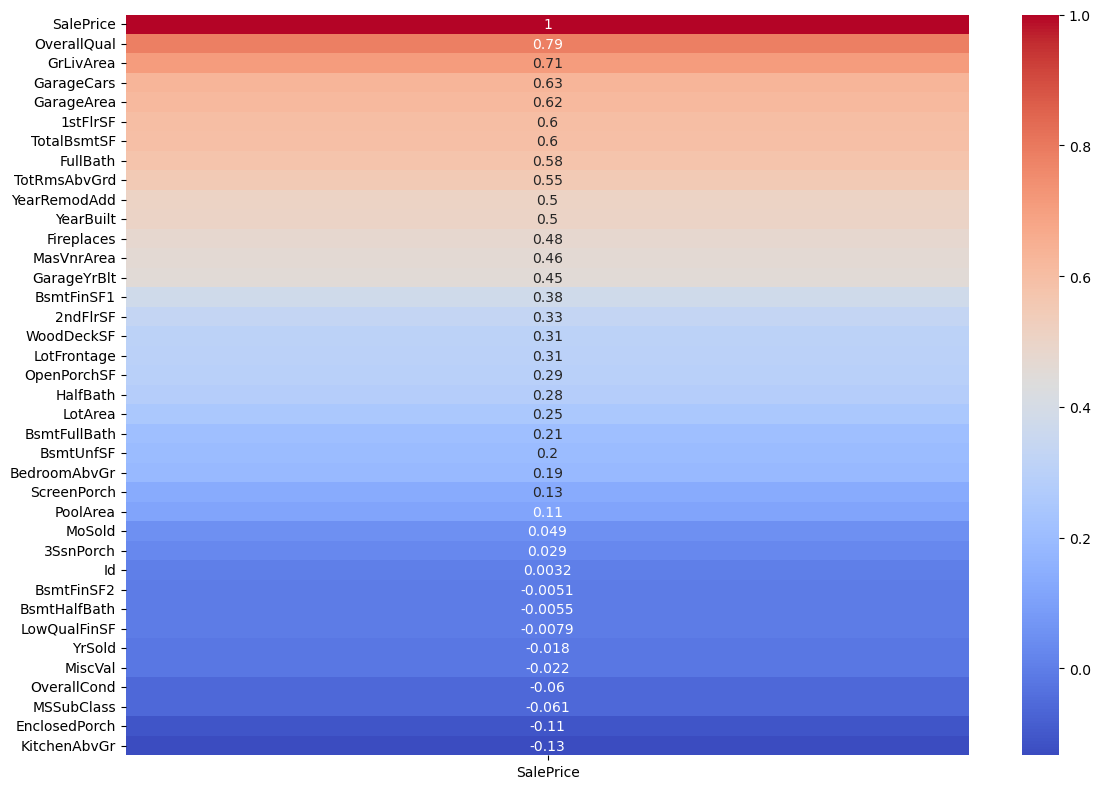

In [17]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [18]:
top8_cols = corr['SalePrice'].abs().sort_values(ascending=False)[1:].head(8).index.to_list()

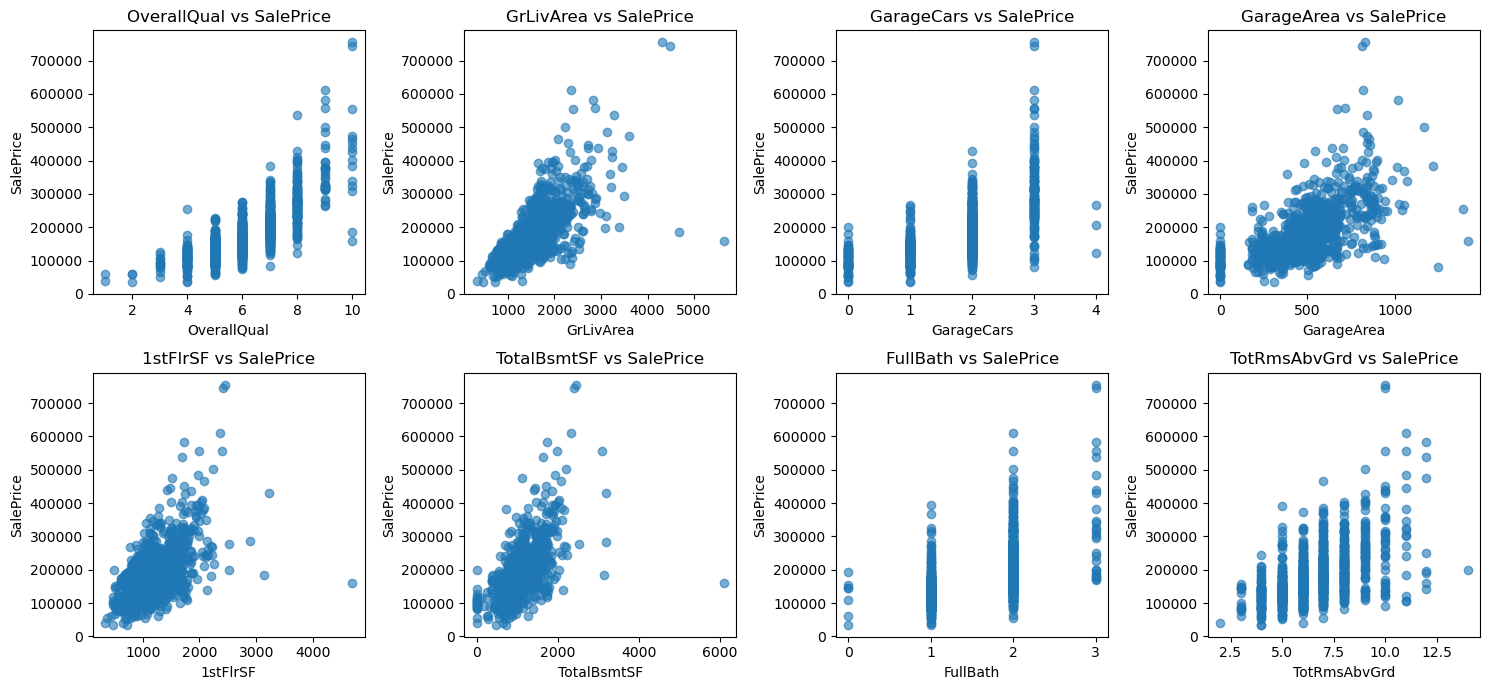

In [19]:
# subplot 설정 (2행 4열)
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()  # 2차원 배열을 1차원으로 변환해서 인덱싱 편하게

# 각 컬럼 vs SalePrice scatter plot
for i, col in enumerate(top8_cols):
    axes[i].scatter(train_df[col], train_df['SalePrice'], alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')
    axes[i].set_title(f'{col} vs SalePrice')

plt.tight_layout()
plt.show()

- 강한 양의 상관관계를 보이는 특성들 (r >= 0.5)
    - OverallQual (자재 및 마감 품질 종합 평가)
    - GrLivArea (지상 생활공간 면적)
    - GarageCars (주차 가능 대 수)
    - GarageArea (차고 면적)
    - 1stFlrSF (1층 면적)
    - TotalBsmtSF (지하실 면적)
    - FullBath (지상 완비 욕실수)
    - TotRmsAbvGrd (지상 전체 방개수)

#### Year와 SalePrice 관계 조사 

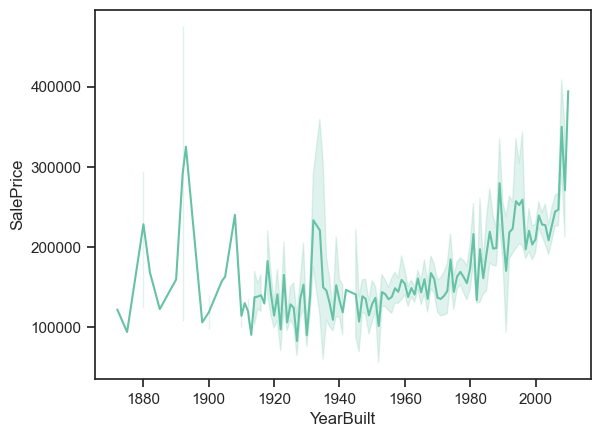

In [20]:
sns.set(style="ticks", palette="Set2")
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.show()

- 전반적으로 연식이 최신일수록 가격은 우상향 한다.
- 하지만 1880~1990년 사이 매우 높은 피크: 특별한 건축 양식? 유행?
- 가장 가격이 높은 집은 1892 - 1893 순

In [21]:
peak_df = train_df[(train_df.SalePrice > 300000) & (train_df.YearBuilt < 1900)]
peak_df['YearBuilt']

68     1893
776    1892
Name: YearBuilt, dtype: int64

- 1892년과의 유사도를 통한 새로운 변수 생성 준비

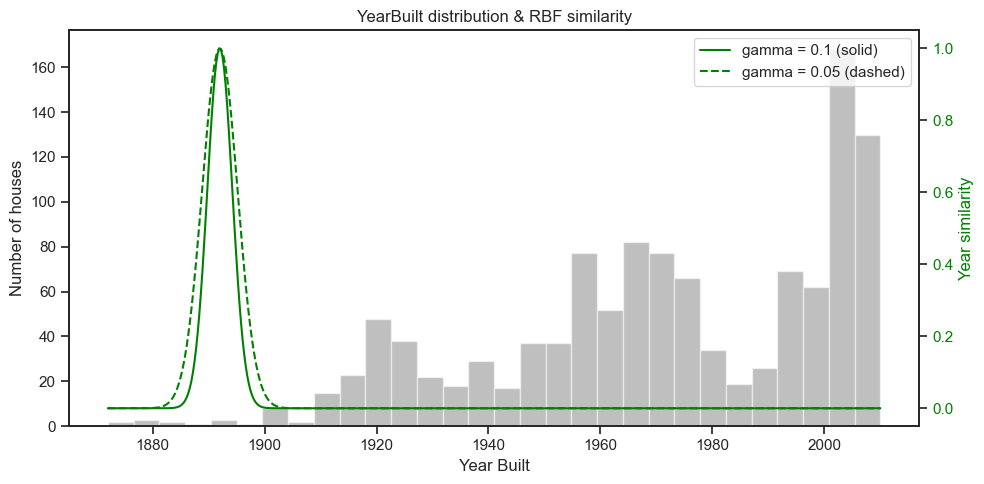

In [22]:
# YearBuilt 유사도 계산
years = np.linspace(train_df['YearBuilt'].min(),
                    train_df['YearBuilt'].max(),
                    500).reshape(-1, 1)

# 기준 연도
target_year = 1892

# gamma 값 설정
gamma1 = 0.1
gamma2 = 0.05

# RBF 커널 계산
rbf_1 = rbf_kernel(years, [[target_year]], gamma=gamma1)
rbf_2 = rbf_kernel(years, [[target_year]], gamma=gamma2)

# 시각화
fig, ax1 = plt.subplots(figsize=(10,5))

# 히스토그램: YearBuilt 분포
ax1.set_xlabel('Year Built')
ax1.set_ylabel('Number of houses')
ax1.hist(train_df['YearBuilt'], bins=30, alpha=0.5, color='gray')
ax1.set_title('YearBuilt distribution & RBF similarity')

# RBF 곡선: gamma 2개
ax2 = ax1.twinx()
ax2.plot(years, rbf_1, color='green', label=f'gamma = {gamma1} (solid)')
ax2.plot(years, rbf_2, color='green', linestyle='--', label=f'gamma = {gamma2} (dashed)')
ax2.set_ylabel('Year similarity', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 범례
ax2.legend()

plt.tight_layout()
plt.show()

### 1-5. 특정구간 이상치 제거

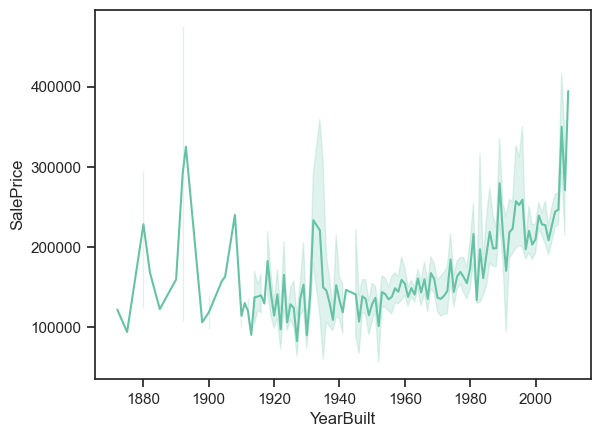

In [23]:
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.show()

- 1940년 이전에 집값 이상치 가능성

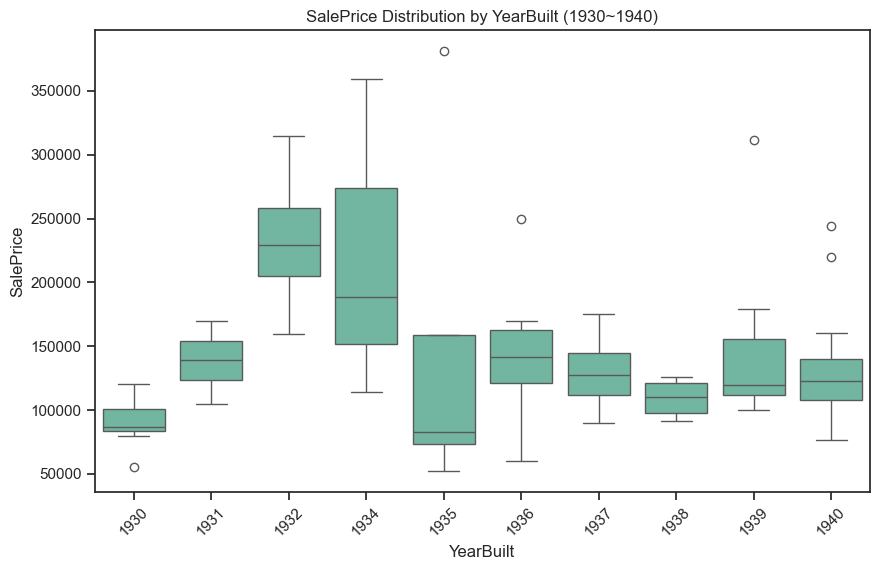

In [24]:
# 1930~1940 사이 데이터 필터링
subset = train_df[(train_df['YearBuilt'] >= 1930) & (train_df['YearBuilt'] <= 1940)]

# 박스플롯
plt.figure(figsize=(10,6))
sns.boxplot(x='YearBuilt', y='SalePrice', data=subset)
plt.title('SalePrice Distribution by YearBuilt (1930~1940)')
plt.ylabel('SalePrice')
plt.xlabel('YearBuilt')
plt.xticks(rotation=45)
plt.show()

- 1935 - 1930년 사이의 이상치 보이는 샘플 제거

In [25]:
# IQR 계산
Q1 = subset['SalePrice'].quantile(0.25)
Q3 = subset['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 범위 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 아닌 인덱스 선택
non_outliers_idx = subset[(subset['SalePrice'] >= lower_bound) & (subset['SalePrice'] <= upper_bound)].index

# 원본 데이터에서 이상치 제거
train_df.drop(subset.index.difference(non_outliers_idx), inplace=True, errors='ignore')

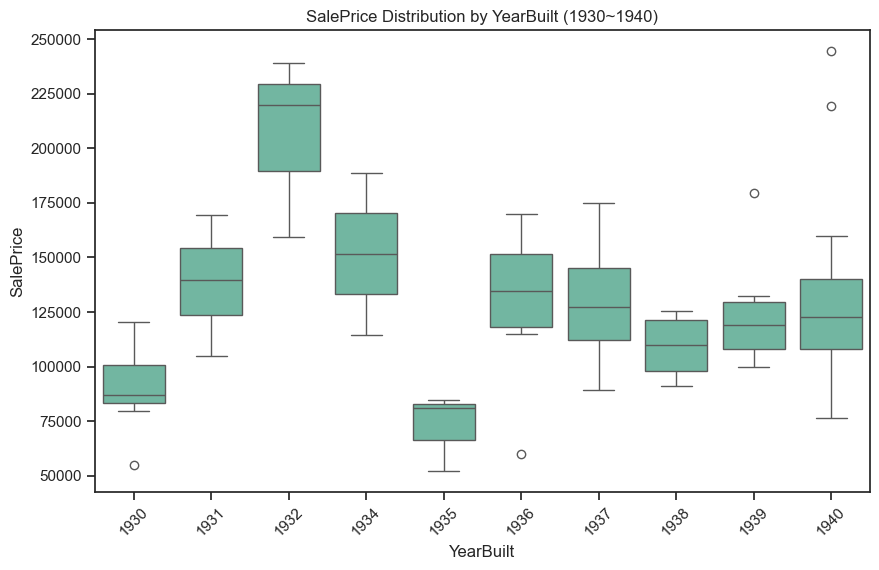

In [26]:
# 1930~1940 사이 데이터 필터링
subset = train_df[(train_df['YearBuilt'] >= 1930) & (train_df['YearBuilt'] <= 1940)]

# 박스플롯
plt.figure(figsize=(10,6))
sns.boxplot(x='YearBuilt', y='SalePrice', data=subset)
plt.title('SalePrice Distribution by YearBuilt (1930~1940)')
plt.ylabel('SalePrice')
plt.xlabel('YearBuilt')
plt.xticks(rotation=45)
plt.show()

In [27]:
train_df.shape

(1163, 79)

- 1935년의 특별한 이상치 포함 5샘플 삭제 (1168 -> 1163)

## 2. Feature Engineering

In [28]:
def feature_engineering(df, target_year=1892, gamma=0.05):
    df = df.copy()

    # 총 면적
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # 토지(LotArea) 대비 건물 면적(TotalSF) 비율
    df['BuildingLotRatio'] = df['TotalSF'] / df['LotArea']

    # 토지(LotArea) 대비 지상 생활공간(GrLivArea) 비율
    df['LivingAreaRatio'] = df['GrLivArea'] / df['LotArea']

    # 방당 면적
    df['AvgRoomArea'] = df['GrLivArea'] / df['TotRmsAbvGrd']

    # 총면적 대비 지상 방 개수
    df['RoomDensity'] = df['TotRmsAbvGrd'] / df['TotalSF']

    # 면적 대비 욕실 수 비율 (full = 1, half = 0.5)
    df['BathDensity'] = (df['FullBath'] + 0.5*df['HalfBath']) / df['TotalSF']

    # RBF similarity 계산
    year_values = df['YearBuilt'].values.reshape(-1, 1)
    year_similarity = rbf_kernel(year_values, [[target_year]], gamma=gamma)
    df['YearSimilarity'] = year_similarity.flatten()

    # 집의 나이
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']

    # 리모델링 후 기간
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']

    # Boolean 특성
    df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)

    # Qualitative 변수 숫자로 매핑
    qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    for col in ['ExterQual', 'KitchenQual', 'GarageQual', 'BsmtQual']:
        if col in df.columns:
            df[col] = df[col].map(qual_map)

    # Id 제거
    df.drop(columns=['Id'], inplace=True, errors='ignore')

    # # 필요없는 컬럼 제거
    # # 거의 모든값이 동일한 경우
    # df.drop(columns=['Utilities', 'Street'], inplace=True, errors='ignore')
   
    # # 피쳐 엔지니어링 이후 필요 없어진 컬럼
    # df.drop(columns=['YrSold', 'MoSold'], inplace=True, errors='ignore')
   
    # # 가격에 별로 영향이 없을 것 같은 컬럼
    # df.drop(columns=['SaleType', 'SaleCondition'], inplace=True, errors='ignore')

    return df

In [29]:
train_df = feature_engineering(train_df)

- 거의 모든값이 동일한 경우

In [30]:
train_df.drop(columns=['Utilities', 'Street'], inplace=True, errors='ignore')

- 피쳐 엔지니어링 이후 필요 없어진 컬럼

In [31]:
train_df.drop(columns=['YrSold', 'MoSold'], inplace=True, errors='ignore')

- 가격에 별로 영향이 없을 것 같은 컬럼

In [32]:
train_df.drop(columns=['SaleType', 'SaleCondition'], inplace=True, errors='ignore')

## 3. Model Selection

In [33]:
X = train_df.drop(columns='SalePrice')
y = train_df['SalePrice']

In [34]:
def create_preprocessor_and_run(X, scaler=StandardScaler()):
    # object 타입 컬럼 추출
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # 수치형 처리: NaN → 평균 대체 후 스케일링
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', scaler)
    ])

    # 범주형 처리: NaN → 'Missing' 대체 후 원핫인코딩
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # or fill_value="Missing"
        ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # preprocessor 생성
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # 전처리 후 데이터 변환
    X_processed = preprocessor.fit_transform(X)

    # X_processed는 numpy 배열이므로, 나중에 DataFrame으로 변환
    cat_encoder = preprocessor.named_transformers_['cat']['encoder']
    encoded_cols = cat_encoder.get_feature_names_out(cat_cols)
    all_cols = num_cols + encoded_cols.tolist()

    # 반환
    return preprocessor, pd.DataFrame(X_processed, columns=all_cols, index=X.index)

In [35]:
# Standard scaler 사용 데이터 전처리
preprocessor, X_prep = create_preprocessor_and_run(X)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_prep, y, test_size=0.2, random_state=42
)

In [37]:
# 모델 정의
models = {
    'lr': LinearRegression(),
    'rf': RandomForestRegressor(n_estimators=100, random_state=42),
    'xgb': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'lgbm': lgb.LGBMRegressor(n_estimators=100, random_state=42),
}

from sklearn.metrics import r2_score

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)

     # 결과 저장
    results[name] = {'RMSE': rmse, 'R2': r2}

# DataFrame으로 보기
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4626
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 134
[LightGBM] [Info] Start training from score 179833.798925


,RMSE,R2
rf,31972.887194,0.792710
lgbm,32102.044458,0.791032
xgb,36913.586442,0.723696
lr,47834.062936,0.536030


## 4. 하이퍼파라미터 튜닝
- XGB
- LGBM
- RF

In [38]:
# ---------------------------
# Search Space 설정
# ---------------------------
space_dict = {
    'xgb': {
        # 'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10)),
    },
    'lgbm': {
        # 'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
        'max_depth': hp.quniform('max_depth', 3, 12, 1),
        'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10)),
    },
    'rf': {
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'max_depth': hp.quniform('max_depth', 3, 20, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    }
}

In [39]:
# ---------------------------
# objective 함수
# ---------------------------
def objective_func(params, model_type):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(
            n_estimators=500,
            # n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=42,
            n_jobs=-1,
        )
    elif model_type == 'lgbm':
        model = lgb.LGBMRegressor(
            n_estimators=500,
            # n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            num_leaves=int(params['num_leaves']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=42,
            n_jobs=-1,
            verbose=-1,
        )
    elif model_type == 'rf':
        model = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42,
            n_jobs=-1,
        )
    
    # 3-Fold CV RMSE 계산
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    score = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(score)
    return {'loss': rmse, 'status': STATUS_OK}

In [40]:
# ---------------------------
# Hyperopt 실행 - standard scaler
# ---------------------------
models = {}
for model_name, space in space_dict.items():
    trials = Trials()
    best = fmin(fn=lambda p: objective_func(p, model_name),
                space=space,
                algo=tpe.suggest,
                max_evals=30,
                trials=trials,
                rstate=np.random.default_rng(42))
    models[model_name] = best
    print(f'{model_name} best params:', best)

100%|████████████████████████████████████████████████| 30/30 [01:01<00:00,  2.04s/trial, best loss: 30195.145923365453]
xgb best params: {'colsample_bytree': np.float64(0.6096269784788019), 'learning_rate': np.float64(0.09626201852849847), 'max_depth': np.float64(4.0), 'reg_alpha': np.float64(6.033443505049802), 'reg_lambda': np.float64(0.02918836327956969), 'subsample': np.float64(0.9838309588704806)}
100%|█████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74trial/s, best loss: 30347.67299363489]
lgbm best params: {'colsample_bytree': np.float64(0.6284176556968765), 'learning_rate': np.float64(0.01185272774089251), 'max_depth': np.float64(11.0), 'num_leaves': np.float64(33.0), 'reg_alpha': np.float64(0.008014688736675855), 'reg_lambda': np.float64(4.188449942159699), 'subsample': np.float64(0.9635545725730881)}
100%|████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.15trial/s, best loss: 32023.049131459848]
rf best params: {'max_depth': np.

In [41]:
# ---------------------------
# 모델 평가 
# ---------------------------

results = []

for model_name, best_params in models.items():
    params = best_params.copy()
    if model_name == 'xgb':
        params = {
            'n_estimators': 500,
            # 'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'learning_rate': best_params['learning_rate'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'reg_alpha': best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda'],
            'random_state': 42,
            'n_jobs': -1
        }
        model = xgb.XGBRegressor(**params)
    elif model_name == 'lgbm':
        params = {
            'n_estimators': 500,
            # 'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'num_leaves': int(best_params['num_leaves']),
            'learning_rate': best_params['learning_rate'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'reg_alpha': best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda'],
            'random_state': 42,
            'n_jobs': -1
        }
        model = lgb.LGBMRegressor(**params)
    elif model_name == 'rf':
        params = {
            'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'min_samples_split': int(best_params['min_samples_split']),
            'min_samples_leaf': int(best_params['min_samples_leaf']),
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestRegressor(**params)
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_valid)
    
    # 평가 지표
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'R2': r2
    })

# DataFrame 생성
results_df = pd.DataFrame(results)
results_df

,Model,RMSE,R2
0,xgb,34688.977846,0.755995
1,lgbm,29614.547707,0.822162
2,rf,31252.463154,0.801946


In [42]:
test_df = pd.read_csv('./data/housing_price_test.csv')

# Test_data feature engineering
X_test = feature_engineering(test_df)

# 예측에 사용할 column 이름 선택
cols = [col for col in train_df.columns if col != 'SalePrice']

# Test data column filtering
X_test = X_test[cols]

# scaling, encoding
X_test_prep = preprocessor.transform(X_test)

# DataFrame으로 변환
test_prep_df = pd.DataFrame(X_test_prep, columns=X_train.columns, index=X_test.index)

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [12, 21, 28] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
def select_final_model(model_name, best_params):
    if model_name == 'xgb':
        params = {
            'n_estimators': 500,
            # 'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'learning_rate': best_params['learning_rate'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'reg_alpha': best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda'],
            'random_state': 42,
            'n_jobs': -1,
        }
        model = xgb.XGBRegressor(**params)
    elif model_name == 'lgbm':
        params = {
            'n_estimators': 500,
            # 'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'num_leaves': int(best_params['num_leaves']),
            'learning_rate': best_params['learning_rate'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'reg_alpha': best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda'],
            'random_state': 42,
            'n_jobs': -1,
        }
        model = lgb.LGBMRegressor(**params)
    elif model_name == 'rf':
        params = {
            'n_estimators': int(best_params['n_estimators']),
            'max_depth': int(best_params['max_depth']),
            'min_samples_split': int(best_params['min_samples_split']),
            'min_samples_leaf': int(best_params['min_samples_leaf']),
            'random_state': 42,
            'n_jobs': -1,
        }
        model = RandomForestRegressor(**params)
    
    return model

In [48]:
model_name = 'rf'
best_params = models[model_name]

final_model = select_final_model(model_name, best_params)

# train+valid 전체 데이터로 재학습
X_full = pd.concat([X_train, X_valid])
y_full = pd.concat([y_train, y_valid])

final_model.fit(X_full, y_full)

# test set 예측
y_test_pred = final_model.predict(test_prep_df)

# 제출용 DataFrame (캐글 House Prices 예제처럼)
submission = pd.DataFrame({
    'Id': test_df['Id'],   # test 데이터에 Id 컬럼이 있다고 가정
    'SalePrice': y_test_pred
})

submission.to_csv('submission_6.csv', index=False)